In [128]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn

from matplotlib.colors import ListedColormap

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression, SGDClassifier

from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, accuracy_score, roc_curve, auc, RocCurveDisplay

from matplotlib.patches import Patch
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import (
    cross_val_predict,
    KFold,
    ShuffleSplit,
    StratifiedKFold,
    StratifiedShuffleSplit,
    TimeSeriesSplit)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

import warnings
warnings.filterwarnings("ignore")


In [101]:
def isMyModelGood(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot()

    r2 = r2_score(y_test, y_pred)
    print("r^2:", r2)
    mse = mean_squared_error(y_test, y_pred)
    print("MSE test:", mse)

    accuracy = accuracy_score(y_test, y_pred)

    precision = precision_score(y_test, y_pred)

    recall = recall_score(y_test, y_pred)

    f1 = f1_score(y_test, y_pred)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    print(f"Model : Accuracy={accuracy:.3f}, Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")
    print('AUC = ',auc(fpr, tpr) )


In [102]:
#Pipeline
df = pd.read_csv('startup_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                923 non-null    int64  
 1   state_code                923 non-null    object 
 2   latitude                  923 non-null    float64
 3   longitude                 923 non-null    float64
 4   zip_code                  923 non-null    object 
 5   id                        923 non-null    object 
 6   city                      923 non-null    object 
 7   Unnamed: 6                430 non-null    object 
 8   name                      923 non-null    object 
 9   labels                    923 non-null    int64  
 10  founded_at                923 non-null    object 
 11  closed_at                 335 non-null    object 
 12  first_funding_at          923 non-null    object 
 13  last_funding_at           923 non-null    object 
 14  age_first_

In [103]:
#dropping cols, encoding

cols_to_drop = ['Unnamed: 0', 'Unnamed: 6', 'object_id', 'id', 'state_code.1', 'state_code', 'city', 'latitude', 'longitude', 'zip_code', 'name', 'category_code', 'closed_at', 'labels']
df2 = df.drop(columns=cols_to_drop, errors="ignore")

object_cols = df2.select_dtypes(include=["object"]).columns[:3]

for col in object_cols:
    df2[col] = pd.to_datetime(df2[col], errors="coerce") 
    df2[col] = df2[col].view("int64")


df2.info()
col_names = df2.columns.tolist()

impute_cols = ['age_first_milestone_year', 'age_last_milestone_year']
scale_cols = [col for col in df2.columns[0:11] if col not in impute_cols]+[ 'avg_participants']
#will be applying scaler to all features except for categorical features

df2 = pd.get_dummies(df2, columns=['status'], drop_first=True)
df2.info()
#encoding status

# print("cols in df2:", df2.columns.tolist())
# print("impute columns:", impute_cols)
# print("scale columns:", scale_cols)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   founded_at                923 non-null    int64  
 1   first_funding_at          923 non-null    int64  
 2   last_funding_at           923 non-null    int64  
 3   age_first_funding_year    923 non-null    float64
 4   age_last_funding_year     923 non-null    float64
 5   age_first_milestone_year  771 non-null    float64
 6   age_last_milestone_year   771 non-null    float64
 7   relationships             923 non-null    int64  
 8   funding_rounds            923 non-null    int64  
 9   funding_total_usd         923 non-null    int64  
 10  milestones                923 non-null    int64  
 11  is_CA                     923 non-null    int64  
 12  is_NY                     923 non-null    int64  
 13  is_MA                     923 non-null    int64  
 14  is_TX     

In [104]:
#splitting data

x = df2.iloc[:,0:34]
y = df2['status_closed']

#x.info()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=27)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.2, random_state=27)

x_train = x_train.astype(float)
x_test = x_test.astype(float)
x_val = x_val.astype(float)

y_train = y_train.astype(float)
y_test = y_test.astype(float)
y_val = y_val.astype(float)


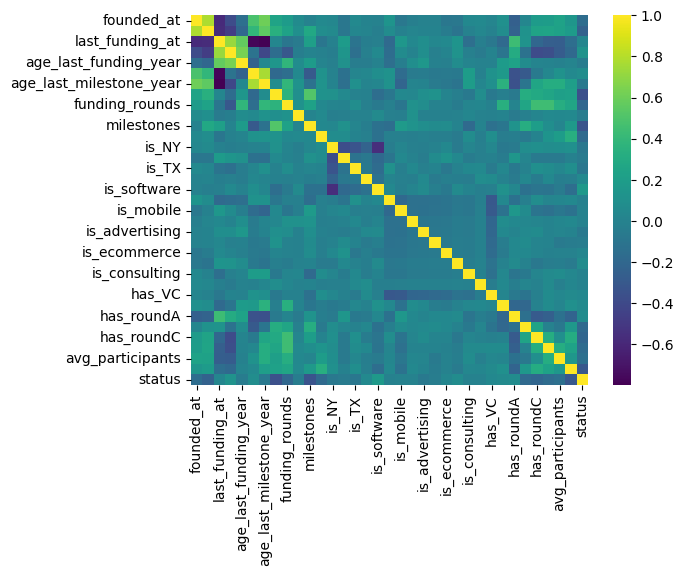

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   founded_at                923 non-null    object
 1   first_funding_at          923 non-null    object
 2   last_funding_at           923 non-null    object
 3   age_first_funding_year    923 non-null    object
 4   age_last_funding_year     923 non-null    object
 5   age_first_milestone_year  923 non-null    object
 6   age_last_milestone_year   923 non-null    object
 7   relationships             923 non-null    object
 8   funding_rounds            923 non-null    object
 9   funding_total_usd         923 non-null    object
 10  milestones                923 non-null    object
 11  is_CA                     923 non-null    object
 12  is_NY                     923 non-null    object
 13  is_MA                     923 non-null    object
 14  is_TX                     

In [105]:
#pipeline

impute_pl = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("impute", impute_pl, impute_cols),
        ("scale", StandardScaler(), scale_cols)
    ],
    remainder="passthrough" #other cols stay the same
)

df2_tf = preprocessor.fit_transform(df2)
df2_tf = pd.DataFrame(df2_tf, columns=col_names)


#dropping columns with a high corr
threshold = .8
corr_matrix = df2_tf.corr()
sns.heatmap(corr_matrix, annot=False, cmap="viridis")
plt.show()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [
    column for column in upper.columns if any(upper[column] > threshold)
]
df_tf = df2_tf.drop(columns=high_corr_features, errors='ignore')
df_tf.info()

print(high_corr_features)

model score: 0.770
AUC =  0.6264594080912299


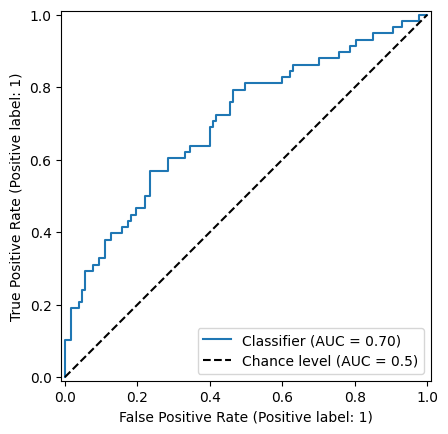

In [132]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clf.fit(x_train, y_train)
print("model score: %.3f" % clf.score(x_val, y_val))  # average accuracy

y_pred=clf.predict(x_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print('AUC = ',auc(fpr, tpr) )
prob=clf.predict_proba(x_test)[:,1]
RocCurveDisplay.from_predictions(y_test, prob,plot_chance_level=True)
plt.show()


r^2: -0.45669291338582685
MSE test: 0.31351351351351353
Model : Accuracy=0.686, Precision=0.500, Recall=0.466, F1=0.482
AUC =  0.6264594080912299
r^2 train: -0.04547269641609253
MSE train: 0.24067796610169492


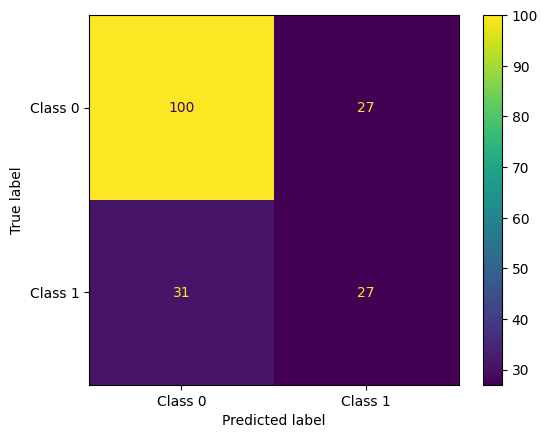

In [133]:
isMyModelGood(y_test, y_pred)
y_train_pred = clf.predict(x_train)

r22 = r2_score(y_train, y_train_pred)
print("r^2 train:", r22)
#both r2 worse than baseline


mse2 = mean_squared_error(y_train, y_train_pred)
print("MSE train:", mse2)
#mse test also worse than baseline, but not by as much like with r2

#gonna test this with more models n see now

In [134]:
y_baseline = [y_train.mean()] * len(y_test)

# MSE for the baseline
baseline_mse = mean_squared_error(y_test, y_baseline)
print("Baseline MSE:", baseline_mse)

Baseline MSE: 0.21732121089776935


In [135]:
#perceptron-adaline
class Adaline:
    def __init__(self, lr=0.01, n_epoch=150):
        self.lr = lr
        self.n_epoch = n_epoch
        self.weight = None
        self.bias = None
    
    #computing weighted sum of inputs and adding bias
    def __func__(self, x):
        return np.dot(x, self.weight) + self.bias
    
    #updating weight and biases for each epoch and gets predictions
    #in each epoch computes output, finds error, computes gradient of loss (mse) and updates weights and biases
    def fit(self, x, y):
        self.weight=np.zeros(x.shape[1])
        self.bias=0

        for _ in range(self.n_epoch):
            output=self.__func__(x)
            error = output-y
            dw = 2*np.dot(error, x)/x.shape[0]
            db = 2*error.mean()

            self.weight = self.weight-self.lr*dw
            self.bias-=self.lr*db
    
    #now we use the model
    def predict(self, x):
        return np.where(self.__func__(x)>=.5, 1,0)


r^2: -0.28088514797719255
MSE test: 0.2756756756756757
Model : Accuracy=0.724, Precision=0.578, Recall=0.448, F1=0.505
AUC =  0.6493347814281836


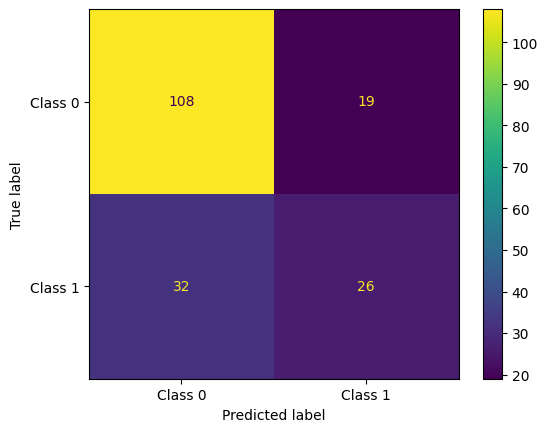

In [136]:
ada = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", Adaline())]
)

ada.fit(x_train, y_train)

y_pred=ada.predict(x_test)

isMyModelGood(y_test, y_pred)
#this is even worse than logistic regresion broooooooo
#also the r2 and mse are exactly the same however the cm is different so idk if this is just a coincidence
#these are both linear models, which might be too simple, the data doesnt look linearly separable, which means linear models wont work well here

#okay actually disregard the above comments i was stupid and forget to pipeline the data before running the model
#its actually somewhat better than LR, but still lacking.
#small improvements are improvements

In [137]:
#custom logistic regression
#cuz the first time was mainly for testing my model

def sigmoid(x):
    return 1/(1+np.exp(-x))

class LogRegSimple():
    def __init__(self, lr=0.1, n_epoch=100):
        self.lr=lr
        self.n_epoch = n_epoch
        self.weights = None
        self.bias = None

    #forward calculates logits (raw score for the sigmoid function)
    #forward = forward pass (duh)
    def forward(self, x):
        return sigmoid(np.dot(x, self.weights)+self.bias)
    
    # fit initializes weights and biases, then for each epoch it makes a prediction and calculates loss, then calculates bias and weights
    def fit(self, x, y):
        self.weights=np.zeros(x.shape[1])
        #had to change from self.weights = np.array([0, 0]) since this doesnt update according to x passed
        self.bias=0

        for epoch in range(self.n_epoch):
            y_pred = self.forward(x)
            loss = (np.dot(-y, np.log(y_pred))-np.dot(1-y, np.log(1-y_pred)))/x.shape[0]

            #note to self --> these are the gradient updates
            self.weights = self.weights+self.lr*np.dot(x.T, y-y_pred)/x.shape[0]
            self.bias+=self.lr*(y-y_pred).mean()

        return self
    
    def predict(self, x):
        return self.forward(x).round()
    def param(self):
        return self.weights, self.bias

r^2: -0.33111593809394524
MSE test: 0.2864864864864865
Model : Accuracy=0.714, Precision=0.547, Recall=0.500, F1=0.523
AUC =  0.6555118110236221


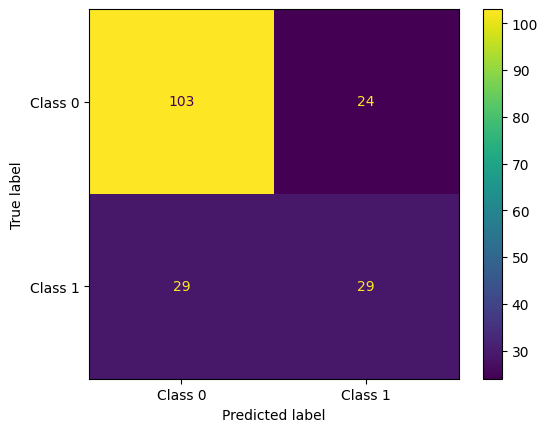

In [138]:
logreg = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogRegSimple(lr=0.1,n_epoch=200))]
)

logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)


isMyModelGood(y_test, y_pred)

#better in some aspects, worse in others, but better than the library included logreg, prob because of the params i passed
#r2 and mse still trash tho

In [139]:
#svm

class SVM:
    def __init__(self, lr = .01, lambda_param=0.01, n_epoch = 1000):
        self.lr = lr
        self.lambda_param=lambda_param
        self.n_epoch=n_epoch
        self.weights=None
        self.bias=None

    #just in general, fit optimizes weights and bias of models
    #here it uses a hinge loss function w gradient descent
    def fit(self, x, y):
        n_samples, n_features = x.shape

        #just recodes labels, turning -1 to 1
        yc = np.where(y <=0, -1, 1)

        self.weights = np.zeros(n_features)
        self.bias=0

        #training loop
        for _ in range(self.n_epoch):
            #updates weights and bias for each training sample
            for idx, x_i in enumerate(x):
                condition = yc[idx] * (np.dot(x_i, self.weights) - self.bias) >= 1
                if condition:
                    #here, if the sample is classified correctly 0 loss
                    self.weights -= self.lr*(2*self.lambda_param*self.weights)
                else:
                    #otherwise hinge loss gradient will be applied (and regularization term)
                    self.weights -= self.lr*(2*self.lambda_param*self.weights-np.dot(x_i, yc[idx]))
                    self.bias-=self.lr*yc[idx]
    
    def predict(self, x):
        approx = np.dot(x, self.weights) - self.bias
        #return np.sign(approx)
        #needs to be removed since getting 3 labels, need to be binary for metrics
        return np.where(approx >=0, 1, 0)

r^2: -0.3813467282106979
MSE test: 0.2972972972972973
Model : Accuracy=0.703, Precision=0.533, Recall=0.414, F1=0.466
AUC =  0.6242193863698072


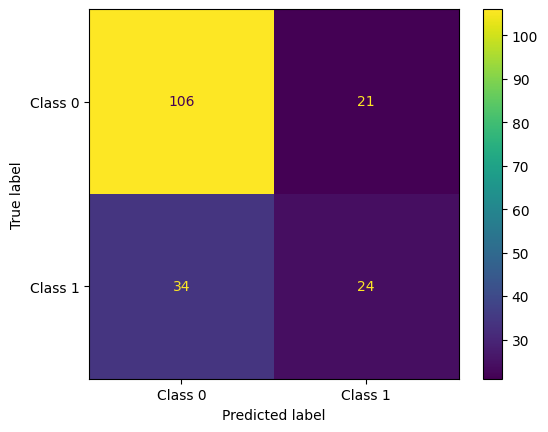

In [140]:
svm = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", SVM(lr=.01, lambda_param=.01, n_epoch=1000))]
)
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)

isMyModelGood(y_test, y_pred)

#worse than the other two, prob because its also a linear model

r^2: -0.4315775183274506
MSE test: 0.3081081081081081
Model : Accuracy=0.692, Precision=0.509, Recall=0.500, F1=0.504
AUC =  0.639763779527559


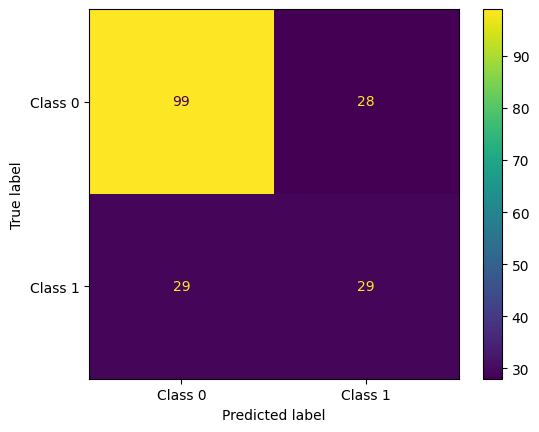

In [141]:
#decision tree

tree = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier(criterion="entropy"))]
)

tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)

isMyModelGood(y_test, y_pred)

#not great but rf should improve on this at least

In [142]:
#rf
rf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier(n_estimators=100, max_depth=5, random_state=27))]
)
cv_scores = 
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

isMyModelGood(y_test, y_pred)

#a lot better than the others
#r2 is finally positive, even if by the smallest amount

SyntaxError: invalid syntax (1254525533.py, line 5)